In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px 
import plotly.graph_objects as go 
import seaborn as sns 
from pingouin import ttest

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import optuna

### Carregar dados

In [2]:
df_frutas = pd.read_csv('./datasets/fruit.csv')

In [3]:
df_frutas.head(10)

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
5,5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,bad
6,6,1.331606,1.635956,0.875974,-1.677798,3.106344,-1.847417,2.414171,good
7,7,-1.995462,-0.428958,1.530644,-0.742972,0.158834,0.974438,-1.470125,good
8,8,-3.867632,-3.734514,0.986429,-1.207655,2.292873,4.080921,-4.871905,bad
9,9,-0.727983,-0.442820,-4.092223,0.597513,0.393714,1.620857,2.185608,bad


In [4]:
df_frutas.tail(10)

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3990,3990,-1.396794,-0.599596,-1.931104,1.815668,1.670732,1.614027,-0.987968,bad
3991,3991,-4.007762,2.970164,0.218167,-0.492369,1.656375,-2.133895,-4.431321,good
3992,3992,1.764253,-2.079695,-0.083383,-0.086724,-1.703385,3.840101,-0.338261,good
3993,3993,1.520142,-0.352623,-3.206467,1.341719,0.675568,0.107093,-0.945080,bad
3994,3994,1.482508,-2.581181,-0.306888,1.527877,1.056361,2.560829,-1.229255,good
3995,3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,bad
3996,3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,good
3997,3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,bad
3998,3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,good
3999,3999,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796,good


In [5]:
df_frutas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


### EDA


In [6]:
#Distribuição target percentual
px.bar(df_frutas.value_counts('Quality') / len(df_frutas) * 100)

In [7]:
# tranformar a variavel quality em numerica (0 e 1)
df_frutas['Quality'] = (df_frutas['Quality'] == 'good').astype(int)

In [8]:
# Remover coluna A_id
df_frutas.drop(columns=['A_id'], axis=1, inplace=True)

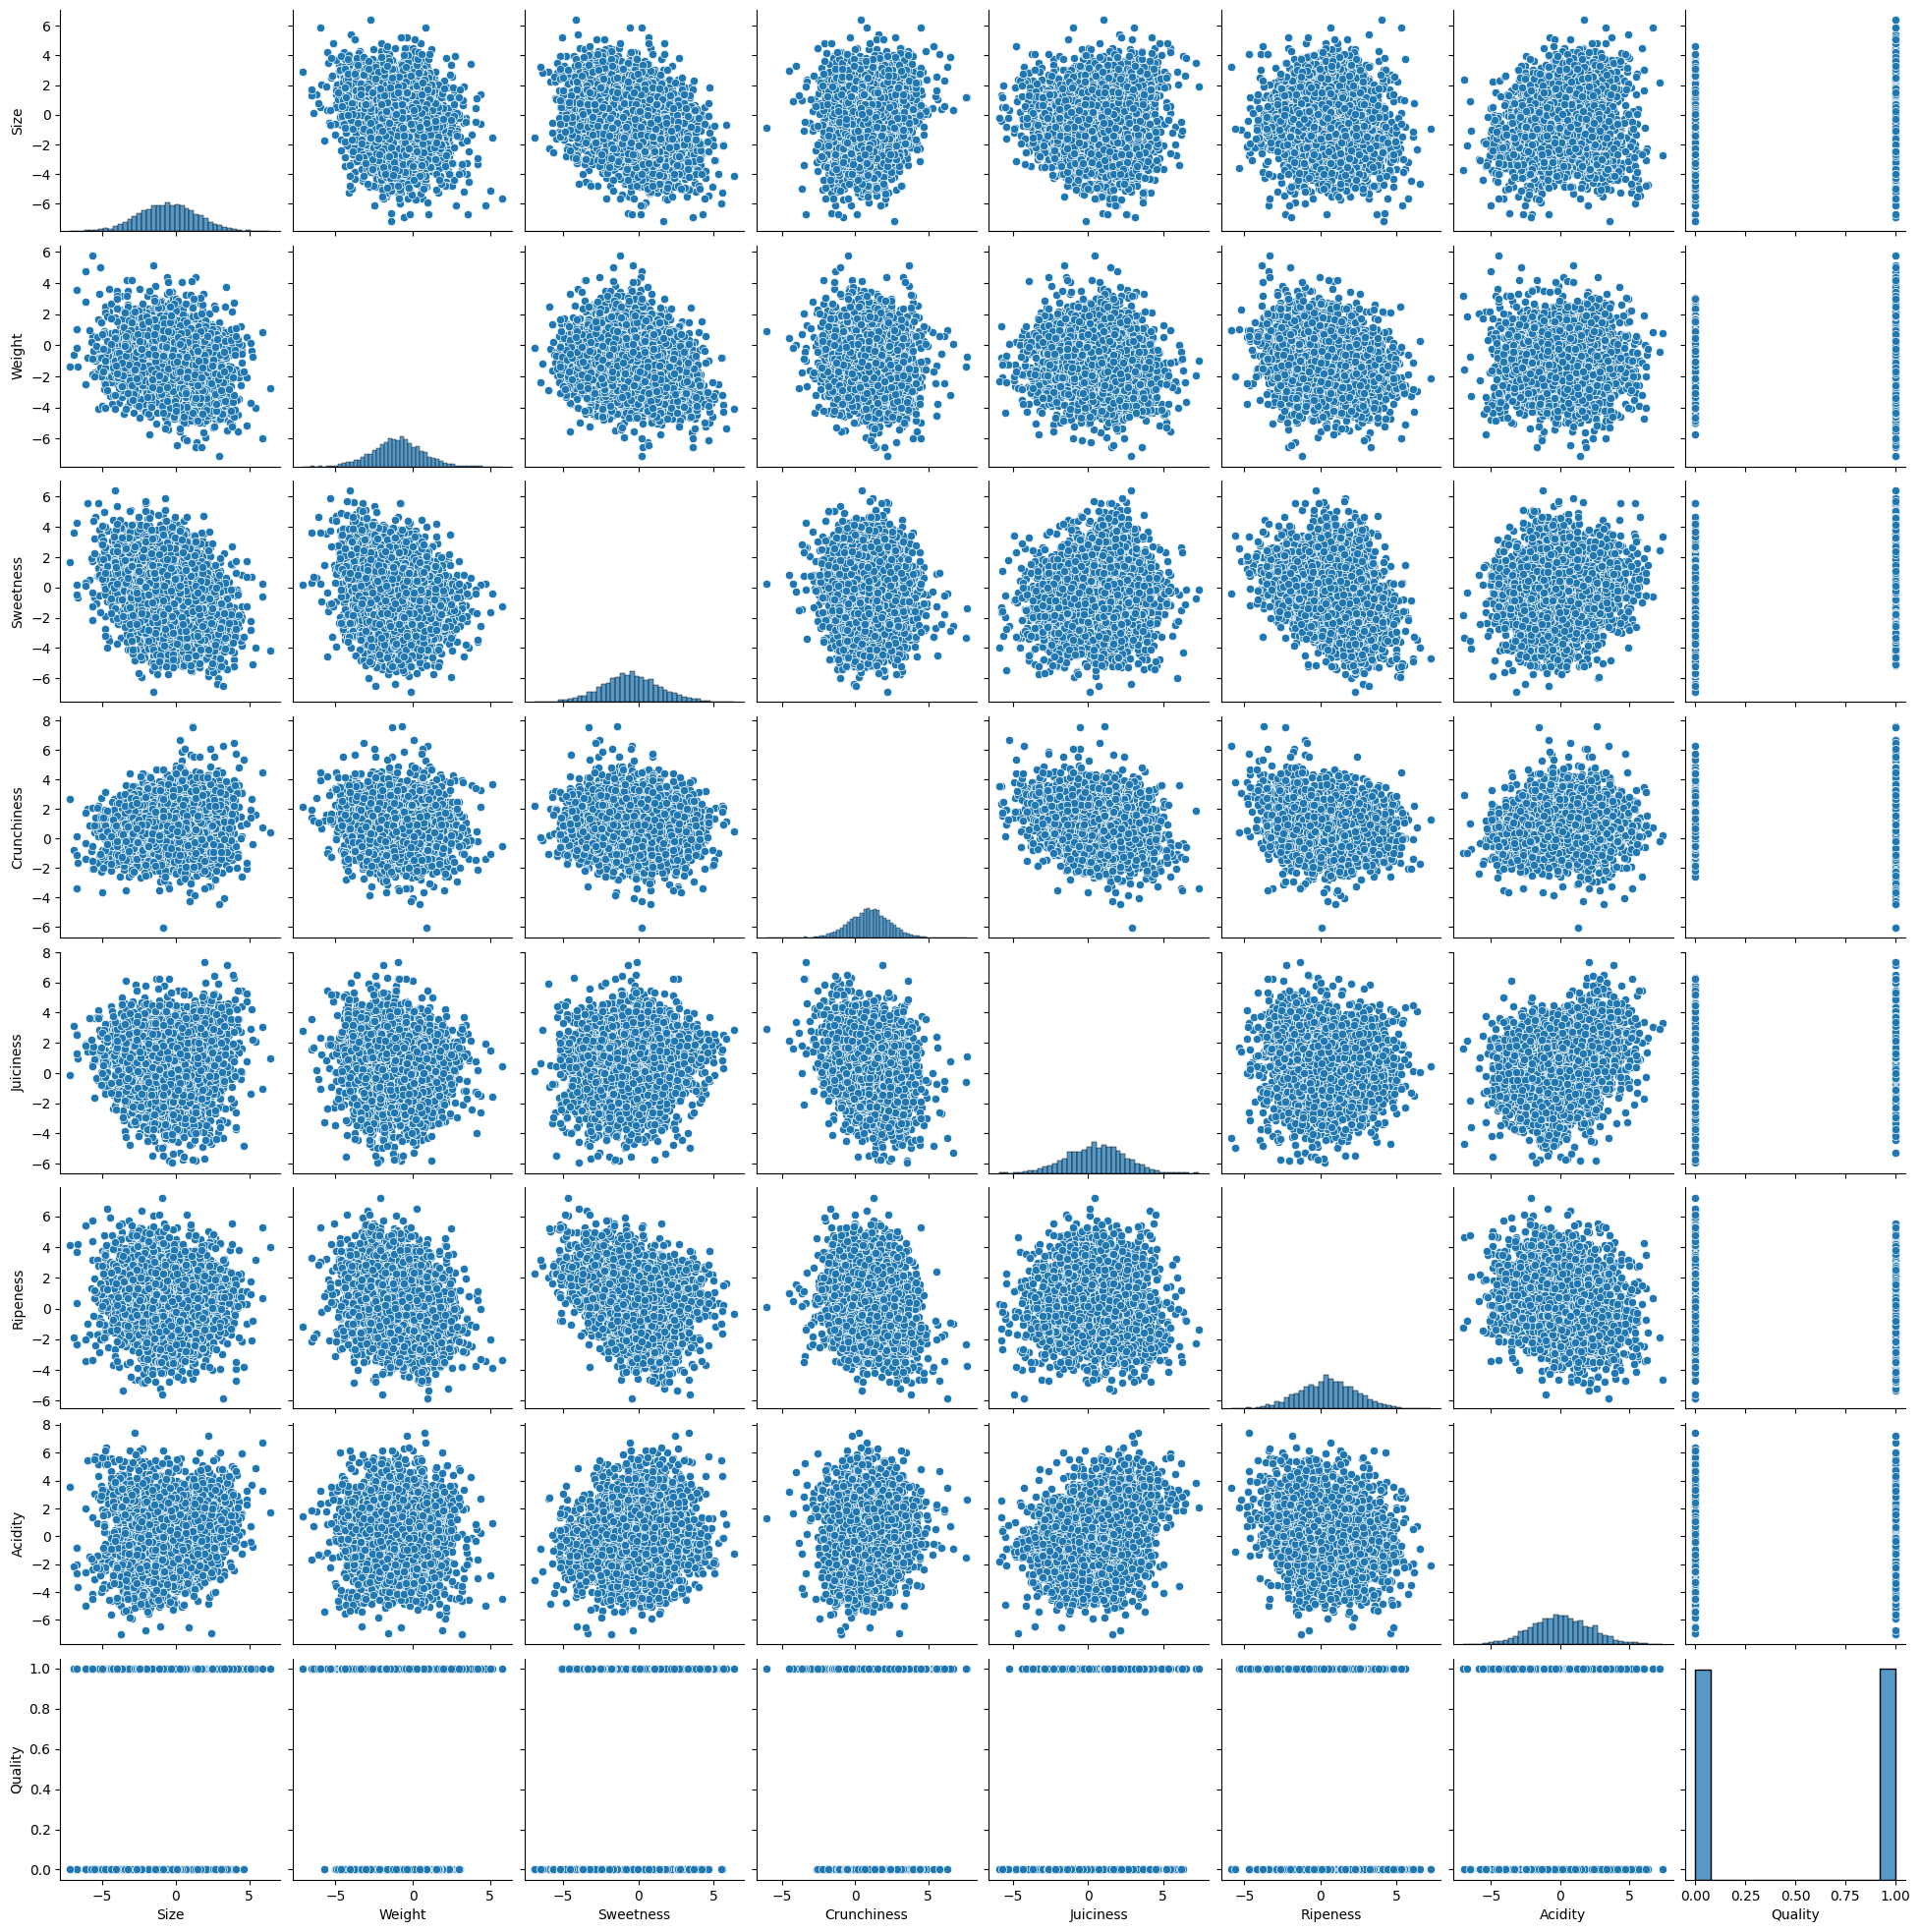

In [9]:
# Verificar distribuição e correlação de variaveis numa forma visual
sns.pairplot(df_frutas, diag_kind='hist')

In [10]:
# Boxplot relacionando quality com weight
px.box(df_frutas, x='Quality', y='Weight', color='Quality')

In [11]:
# Boxplot relacionando quality com sweetness
px.box(df_frutas, x='Quality', y='Sweetness', color='Quality')

In [12]:
# Boxplot relacionando quality com Size
px.box(df_frutas, x='Quality', y='Size', color='Quality')

In [13]:
# Diferenciar médias de dois grupos
#teste de tstudent
#h0 nao ha diferença significativa entre as medias dos grupos e h1 há um diferença

grupo_good_weight = df_frutas[df_frutas['Quality'] ==1]['Weight']
grupo_bad_weight = df_frutas[df_frutas['Quality'] ==0]['Weight']
ttest(x=grupo_good_weight, y=grupo_bad_weight, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.089906,3599.742464,two-sided,0.928367,"[-0.09, 0.1]",0.002841,0.036,0.050925


não ha diferença significativa entre peso e qualidade de acordo com o pvalue 0.92

In [14]:
# Diferenciar médias de dois grupos
#teste de tstudent
#h0 nao ha diferença significativa entre as medias dos grupos e h1 há um diferença

grupo_good_Sweetness = df_frutas[df_frutas['Quality'] ==1]['Sweetness']
grupo_bad_Sweetness = df_frutas[df_frutas['Quality'] ==0]['Sweetness']
ttest(x=grupo_good_Sweetness, y=grupo_bad_Sweetness, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.396437,3995.125489,two-sided,1.590329e-58,"[0.86, 1.09]",0.51847,7.576e+54,1.0


Há uma diferença significativa entre qualidade e doçura

In [15]:
# Diferenciar médias de dois grupos
#teste de tstudent
#h0 nao ha diferença significativa entre as medias dos grupos e h1 há um diferença

grupo_good_Size = df_frutas[df_frutas['Quality'] ==1]['Size']
grupo_bad_Size = df_frutas[df_frutas['Quality'] ==0]['Size']
ttest(x=grupo_good_Size, y=grupo_bad_Size, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.912978,3951.450727,two-sided,2.602204e-55,"[0.82, 1.06]",0.5031,5.053e+51,NaN


Há uma diferença significativa entre qualidade e tamanho

In [16]:
# Corr Matrix
corr_matrix = df_frutas.corr()
corr_matrix

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
Size,1.000000,-0.170702,-0.324680,0.169868,-0.018892,-0.134773,0.196218,0.244007
Weight,-0.170702,1.000000,-0.154246,-0.095882,-0.092263,-0.243824,0.016414,0.001421
Sweetness,-0.324680,-0.154246,1.000000,-0.037552,0.095882,-0.273800,0.085999,0.250998
Crunchiness,0.169868,-0.095882,-0.037552,1.000000,-0.259607,-0.201982,0.069943,-0.012376
Juiciness,-0.018892,-0.092263,0.095882,-0.259607,1.000000,-0.097144,0.248714,0.260223
Ripeness,-0.134773,-0.243824,-0.273800,-0.201982,-0.097144,1.000000,-0.202669,-0.264315
Acidity,0.196218,0.016414,0.085999,0.069943,0.248714,-0.202669,1.000000,-0.007697
Quality,0.244007,0.001421,0.250998,-0.012376,0.260223,-0.264315,-0.007697,1.000000


In [17]:
#Plot heatmap
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr_matrix.columns,
        y = corr_matrix.index,
        z = np.array(corr_matrix),
        text = corr_matrix.values,
        texttemplate='%{test:.2f}',
        colorscale=px.colors.diverging.RdBu,
        zmin=-1, 
        zmax=1,
    )
)

fig.show()

### Treinar modelo Baseline

In [18]:
X = df_frutas.drop(columns=['Quality'], axis=1)
y = df_frutas['Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

In [19]:
#Criar o objeto do algoritmo logistico
# para datasets pequenos o solver liblinear é um dos indicados na documentação do sklearn
model_lr = LogisticRegression(solver='liblinear')


In [20]:
#Treinar modelo
model_lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

### Metricas Baseline

In [21]:
#retornar a classificação predita com base no conjunto de testes
y_pred = model_lr.predict(X_test)

In [22]:
y_pred

array([0, 1, 1, ..., 1, 1, 0], shape=(1200,))

In [23]:
#decision function retorna o valor calculado (score) de cada instancia considerando os coeficiente obtidos na reta de regressao
y_decision = model_lr.decision_function(X_test)
y_decision

array([-0.62262518,  0.03737776,  0.24573024, ...,  0.2610187 ,
        0.4326487 , -2.21871192], shape=(1200,))

In [24]:
# Retornar as probabilidades de cada classe para cada instancia no conjunto de testes
y_prob =  model_lr.predict_proba(X_test)
y_prob

array([[0.65081537, 0.34918463],
       [0.49065665, 0.50934335],
       [0.43887471, 0.56112529],
       ...,
       [0.43511331, 0.56488669],
       [0.39349402, 0.60650598],
       [0.90191731, 0.09808269]], shape=(1200, 2))

In [25]:
#Retornar os valores da curva roc - TPR(True positive rate) FPR(Falso positivo), Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_decision)

In [26]:
#Calcular auc ( Area under the curve)
roc_auc = auc(fpr, tpr)
roc_auc

np.float64(0.8414568425263345)

In [27]:
# Plotar curva roc com valor auc
fig = px.area(
    x=fpr, y=tpr,
    title=f'Curva Roc (Auc = {roc_auc})',
labels=dict(x='FPR', y='TPR'),
width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=1
)
fig.update_yaxes(scaleanchor='x', scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [28]:
# Apresentar a importancia das features com base nos coeficientes obtidos na regressão
importance = np.abs(model_lr.coef_)

#exibir a importancia das features
for i, feature in enumerate(model_lr.feature_names_in_):
    print(f'{feature}: {importance[0][i]}')

Size: 0.6049754259658939
Weight: 0.250178894526485
Sweetness: 0.5488782226573184
Crunchiness: 0.023646688656387905
Juiciness: 0.4354811581239467
Ripeness: 0.12462577365881079
Acidity: 0.2773317065762495


In [29]:
# f1 score é uma media harmonica entre precisão e recall
f1_score_baseline = f1_score(y_test, y_pred)
f1_score_baseline

0.7787903893951947

In [30]:
#apresentar BCE - log loss
log_loss(y_test, y_pred)

8.019712879078565

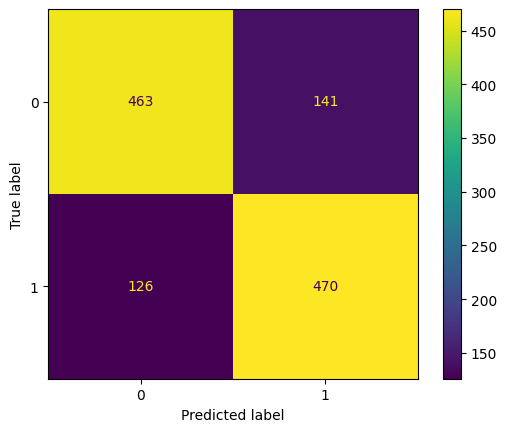

In [31]:
#mostrar matrix de confusão
confusion_matrix_modelo = confusion_matrix(y_test, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix_modelo)
disp.plot()

### Otimizar hiperparametros

In [37]:
#ajustar hiper com optuna

# hiper penalty
# regularização controla a complexidade do modelo, reduzindo o overfitting
# L1 (ridge) util para find de feature selection e para modelos esparsos. Soma dos valores absolutos dos coeficientes
# L2 (lasso) é util para evitar overfitting quando ha multicolinieridade. soma dos quadados dos coeficientes

# Hiper C
# valores maiores que C, indica uma regularização mais fraca e ao contrario mais forte
def lr_optuna(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    c_values = trial.suggest_categorical('c', [100, 10, 1.0, 0.1, 0.01])

    model_lr_optuna = LogisticRegression(solver='liblinear', penalty=penalty, C=c_values)
    model_lr_optuna.fit(X_train, y_train)

    y_decision_optuna = model_lr_optuna.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_decision_optuna)
    roc_auc_optuna = auc(fpr, tpr)

    y_pred_optuna = model_lr_optuna.predict(X_test)
    f1_score_optuna = f1_score(y_test, y_pred_optuna, average='macro')
    log_loss_optuna = log_loss(y_test, y_pred_optuna)

    return roc_auc_optuna, f1_score_optuna, log_loss_optuna


In [38]:
# Criação de estudo e rodar otimizador
search_space = {'penalty': ['l1', 'l2'], 'c': [100, 10, 1.0, 0.1, 0.01]}
sampler = optuna.samplers.GridSampler(search_space=search_space)
estudo_lr = optuna.create_study(directions=['maximize', 'maximize', 'minimize' ])
estudo_lr.optimize(lr_optuna, n_trials=10)

[I 2025-06-02 16:09:48,705] A new study created in memory with name: no-name-7f89ebd3-125a-4ab7-b1aa-8fdf3d651570
[I 2025-06-02 16:09:48,731] Trial 0 finished with values: [0.8414207298102138, 0.7774924285618052, 8.019712879078565] and parameters: {'penalty': 'l2', 'c': 10}.
[I 2025-06-02 16:09:48,738] Trial 1 finished with values: [0.8413901728965731, 0.7766610831937465, 8.04974925690283] and parameters: {'penalty': 'l1', 'c': 1.0}.
[I 2025-06-02 16:09:48,745] Trial 2 finished with values: [0.8414290635139339, 0.7774924285618052, 8.019712879078565] and parameters: {'penalty': 'l1', 'c': 10}.
[I 2025-06-02 16:09:48,752] Trial 3 finished with values: [0.8408595937597225, 0.7758257051802457, 8.079785634727095] and parameters: {'penalty': 'l1', 'c': 0.1}.
[I 2025-06-02 16:09:48,759] Trial 4 finished with values: [0.8414207298102138, 0.7774924285618052, 8.019712879078565] and parameters: {'penalty': 'l1', 'c': 100}.
[I 2025-06-02 16:09:48,767] Trial 5 finished with values: [0.8383150362238

In [41]:
# Mostrar o melhor resultado
melhor_trial = max(estudo_lr.best_trials, key=lambda t: t.values[1])
print(f'Trial com melhor AUC e F1 e menor BCE:')
print(f'\tnumber: {melhor_trial.number}')
print(f'\tparams: {melhor_trial.params}')
print(f'\tvalues: {melhor_trial.values}')

Trial com melhor AUC e F1 e menor BCE:
	number: 2
	params: {'penalty': 'l1', 'c': 10}
	values: [0.8414290635139339, 0.7774924285618052, 8.019712879078565]


In [43]:
# Mostrar Chart com Trials do estudo
fig = optuna.visualization.plot_pareto_front(estudo_lr)
fig.show()

In [44]:
#comparação entre melhor resultado e baseline
print(f'AUC:baseline={roc_auc} optuna={melhor_trial.values[0]}')

AUC:baseline=0.8414568425263345 optuna=0.8414290635139339


In [47]:
#comparação entre melhor resultado e baseline
print(f'F1:baseline={f1_score_baseline} optuna={melhor_trial.values[1]}')

F1:baseline=0.7787903893951947 optuna=0.7774924285618052


In [46]:
#comparação entre melhor resultado e baseline
print(f'BCE:baseline={log_loss(y_test, y_pred)} optuna={melhor_trial.values[2]}')

BCE:baseline=8.019712879078565 optuna=8.019712879078565


### Verificar metricas com thresholds diferentes

In [51]:
#fazer loop e apresentar o F1score para cada threshold
lista_thresholds = [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

lista_resultados = {'cenario': [], 'resultado': []}
lista_resultados['cenario'].append('baseline')
lista_resultados['resultado'].append(f1_score_baseline)
lista_resultados['cenario'].append('optuna')
lista_resultados['resultado'].append(melhor_trial.values[1])

for novo_threshold in lista_thresholds: 
    y_pred_thresholds = (model_lr.predict_proba(X_test)[:,1] >= novo_threshold).astype(int)
    f1_score_threshold = f1_score(y_test,y_pred_thresholds, average='macro')
    lista_resultados['cenario'].append(str(novo_threshold))
    lista_resultados['resultado'].append(f1_score_threshold)


In [52]:
#Criar dataframe com resultados
df_resultados_thresholds = pd.DataFrame(lista_resultados)

In [53]:
df_resultados_thresholds

,cenario,resultado
0,baseline,0.778790
1,optuna,0.777492
2,0.55,0.758622
3,0.6,0.749562
4,0.65,0.720718
5,0.7,0.688131
6,0.75,0.656890
7,0.8,0.614942
8,0.85,0.548762
9,0.9,0.443542


In [55]:
#apresentar resultados entre dos f1scores
px.line(df_resultados_thresholds, x='cenario', y='resultado')

In [56]:
#salvar modelo
import joblib



In [57]:
joblib.dump(model_lr, 'model_frutas.pkl')

['model_frutas.pkl']